In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import cv2
import ResnetMultichannel.multichannel_resnet
from ResnetMultichannel.multichannel_resnet import get_arch as Resnet

In [4]:
PATH = Path('data')

In [5]:
PATH.ls()

[PosixPath('data/data'),
 PosixPath('data/test'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/Models_Stratified'),
 PosixPath('data/test.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train'),
 PosixPath('data/train.zip'),
 PosixPath('data/Models')]

In [6]:
TRAIN = PATH/'train'
TEST = PATH/'test'
LABELS = PATH/'train.csv'
TEST = PATH/'test'
TEST_CSV = PATH/'sample_submission.csv'

In [7]:
TRAIN.ls()[:5]

[PosixPath('data/train/5b72674c-bb9c-11e8-b2b9-ac1f6b6435d0_green.png'),
 PosixPath('data/train/8715a312-bbc6-11e8-b2bc-ac1f6b6435d0_blue.png'),
 PosixPath('data/train/f2d2625a-bbaa-11e8-b2ba-ac1f6b6435d0_green.png'),
 PosixPath('data/train/35dec6e2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png'),
 PosixPath('data/train/2814cf60-bbac-11e8-b2ba-ac1f6b6435d0_red.png')]

In [8]:
test_df = pd.read_csv(TEST_CSV)
test_fnames = [TEST/o for o in test_df['Id']]

labels = pd.read_csv(LABELS)
labels.head(), len(labels)

(                                     Id   Target
 0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
 1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
 2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
 3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
 4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18, 31072)

In [9]:
test_fnames[:4]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0')]

In [10]:
suffixes = ['_red.png', '_green.png', '_blue.png', '_yellow.png']

In [11]:
def open_im_id(ID, path=TRAIN, sufx=suffixes):
    if str(ID).endswith('.png'):
        ID = str(ID)[:-4]
    else:
        ID = str(ID)
    imnames = [ID + o for o in sufx]
    imgs = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in imnames]
    imgs = np.stack(imgs, 2)
    return Image(pil2tensor(imgs, np.float32).float())

open_func = partial(open_im_id, path=TRAIN, sufx=suffixes)

In [12]:
classes = """
Nucleoplasm  
Nuclear membrane   
Nucleoli   
Nucleoli fibrillar center   
Nuclear speckles   
Nuclear bodies   
Endoplasmic reticulum   
Golgi apparatus   
Peroxisomes   
Endosomes   
Lysosomes   
Intermediate filaments   
Actin filaments   
Focal adhesion sites   
Microtubules   
Microtubule ends   
Cytokinetic bridge   
Mitotic spindle   
Microtubule organizing center   
Centrosome   
Lipid droplets   
Plasma membrane   
Cell junctions   
Mitochondria   
Aggresome   
Cytosol   
Cytoplasmic bodies   
Rods & rings
"""

classes = classes.split('\n')[1:-1]

In [13]:
class CustomImageList(ImageItemList):
    def open(self, fn):
        return open_func(fn)

In [14]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
trn_tfms, val_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.3)

In [15]:
np.random.seed(1)
data = (CustomImageList.from_df(labels, PATH, folder='train', suffix='.png')
          .random_split_by_pct(0.15)
          .label_from_df(sep=' ', classes=[str(i) for i in range(28)])
          .add_test(test_fnames, label='0')
          .transform((trn_tfms, val_tfms), size=224)
          .databunch(bs=64)
          .normalize(protein_stats)
         )

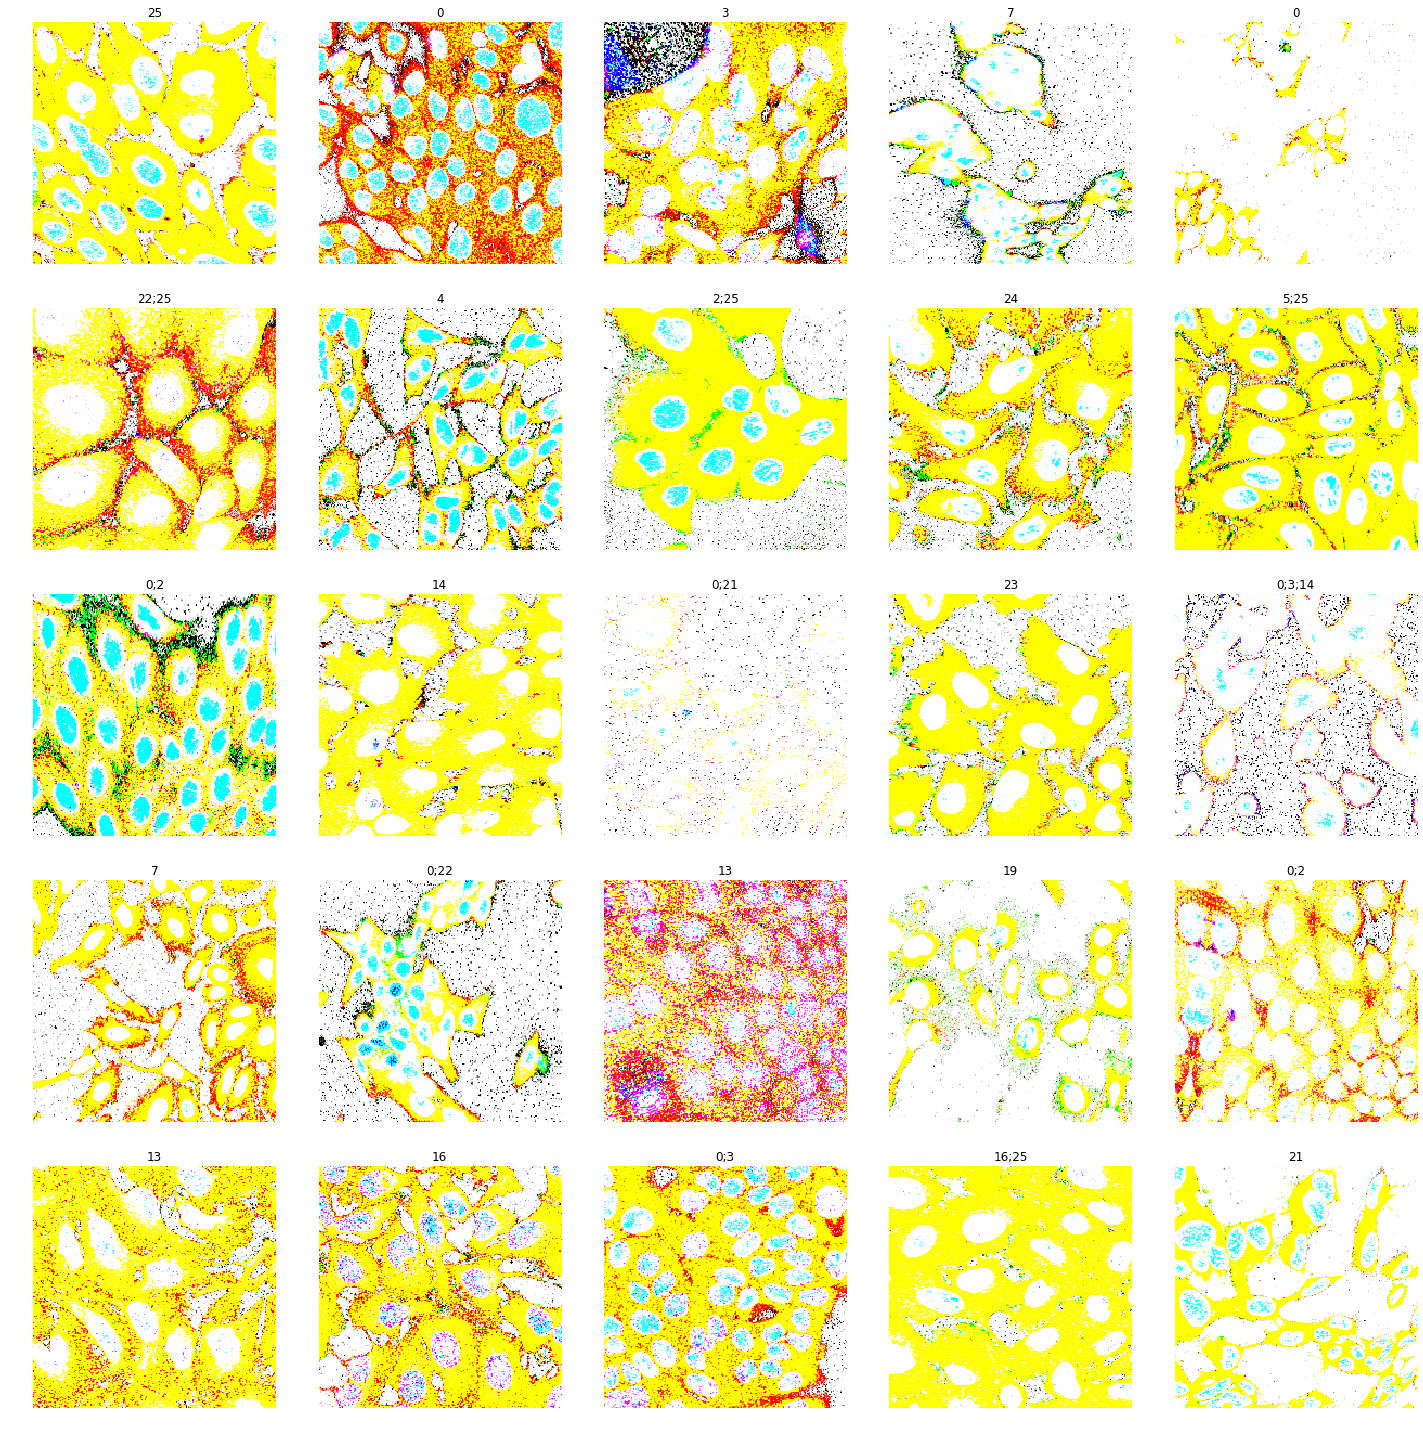

In [16]:
data.show_batch()

# Creating the model

In [17]:
resnet50 = Resnet(50, 4)

In [18]:
f1_score = partial(fbeta, thresh=0.3, beta=1)
acc = partial(accuracy_thresh, thresh=0.3)

In [19]:
MODEL_PATH = 'Models'

In [20]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [21]:
model = create_cnn(data, 
                   resnet50,
                   cut=-2,
                   split_on=_resnet_split, 
                   loss_func=F.binary_cross_entropy_with_logits,
                   path=PATH,
                   metrics=[acc, f1_score],
                   model_dir=MODEL_PATH)

In [167]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


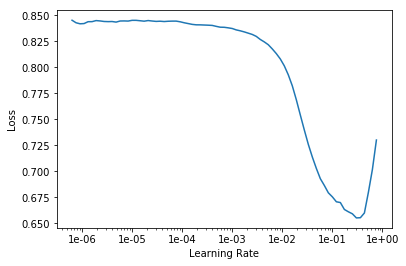

In [168]:
model.recorder.plot()

In [22]:
model.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.173216,0.179649,0.938703,0.294142
2,0.164617,0.161821,0.939393,0.355690
3,0.159982,0.155620,0.944704,0.342960


In [178]:
model.freeze_to(-3)

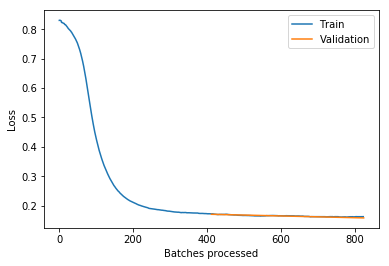

In [179]:
model.recorder.plot_losses()

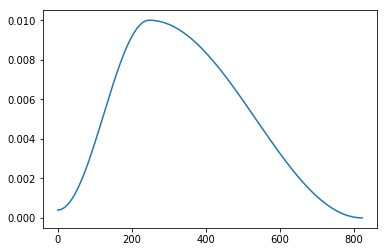

In [181]:
model.recorder.plot_lr()

In [182]:
def find_lr(m = model, start_lr=1e-7, end_lr=10):
    m.lr_find(start_lr, end_lr)
    m.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


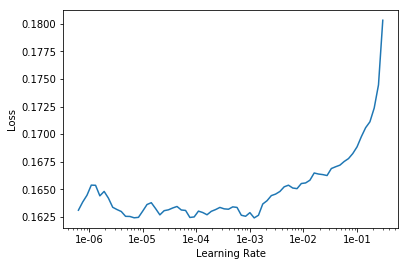

In [183]:
find_lr()

In [184]:
lr = 1e-4
model.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.161169,0.160734,0.935538,0.382647
2,0.157810,0.155145,0.945486,0.384464
3,0.157276,0.149695,0.944398,0.407727
4,0.154200,0.147514,0.946666,0.421850
5,0.151920,0.146316,0.947532,0.427356


In [185]:
model.save('init_r34_basic')

In [186]:
model.path

PosixPath('data')